Authors: Hofmarcher

Date: 20-03-2023

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**.

---


# Imports

Install Gymnasium and dependencies to render the environments

In [1]:
# !apt-get update
# !apt-get install -y swig python3-numpy python3-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python3-opengl libboost-all-dev libsdl2-dev
# !pip install gymnasium==0.29.0 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
# !pip install onnx onnx2pytorch==0.4.1

In [2]:
%matplotlib inline

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
from time import time, strftime
from glob import glob
from tqdm import tqdm
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output
from IPython import display

# Select device for training

By default we train on GPU if one is available, otherwise we fall back to the CPU.
If you want to always use the CPU change accordingly.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


# Setup Google Drive mount to store your results

In [4]:
use_google_drive = False
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Download Dataset and Expert model

In [5]:
# # Download training and validation datasets
# !wget --no-check-certificate 'https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download' -O expert.onnx
# !wget --no-check-certificate 'https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download' -O train.zip
# !wget --no-check-certificate 'https://cloud.ml.jku.at/s/3DxHLiqxTddepp8/download' -O val.zip

# # Unzip datasets
# !unzip -q -o train.zip
# !unzip -q -o val.zip

# Auxiliary Methods

The following cell contains classes and functions to provide some functionality for logging, plotting and exporting your model in the format required by the submission server.
You are free to use your own logging framework if you wish (such as tensorboard or Weights & Biases).
The logger is a very simple implementation of a CSV-file based logger.
Additionally it creates a folder for each run with subfolders for model files, logs and videos.

In [6]:
class Logger():
    def __init__(self, logdir, params=None):
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")

    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))

    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None

    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


def plot_metrics(logger):
    train_loss  = logger.get_values("training_loss")
    train_entropy  = logger.get_values("training_entropy")
    val_loss = logger.get_values("validation_loss")
    val_acc = logger.get_values("validation_accuracy")

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131, label="train")
    ax2 = fig.add_subplot(131, label="val",frame_on=False)
    ax4 = fig.add_subplot(132, label="entropy")
    ax3 = fig.add_subplot(133, label="acc")

    ax1.plot(train_loss, color="C0")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Update (Training)", color="C0")
    ax1.xaxis.grid(False)
    ax1.set_ylim((0,4))

    ax2.plot(val_loss, color="C1")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel('Epoch (Validation)', color="C1")
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.grid(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim((0,4))

    ax4.plot(train_entropy, color="C3")
    ax4.set_xlabel('Update (Training)', color="black")
    ax4.set_ylabel("Entropy", color="C3")
    ax4.tick_params(axis='x', colors="black")
    ax4.tick_params(axis='y', colors="black")
    ax4.xaxis.grid(False)

    ax3.plot(val_acc, color="C2")
    ax3.set_xlabel("Epoch (Validation)", color="black")
    ax3.set_ylabel("Accuracy", color="C2")
    ax3.tick_params(axis='x', colors="black")
    ax3.tick_params(axis='y', colors="black")
    ax3.xaxis.grid(False)
    ax3.set_ylim((0,1))

    fig.tight_layout(pad=2.0)
    plt.show()

"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(video_dir):
    mp4list = glob(f'{video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

# Dataset

Use this dataset class to load the provided demonstrations. Furthermore, this dataset has functionality to add new samples to the dataset which you will need for implementing the DAgger algorithm.

In [7]:
class DemonstrationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob(f"{data_dir}/*.npz"))
        print(f"Loaded {len(self.files)} files from {data_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        state = data["state"][np.newaxis, ...].astype(np.float32)
        action = data["action"]
        return state / 255.0, action.item()

    def append(self, states, actions):
        offset = len(self) + 1
        for i in range(len(states)):
            filename = f"{self.data_dir}/{offset+i:06}.npz"
            np.savez_compressed(filename, state=states[i], action=actions[i].astype(np.int32))
            self.files.append(filename)

# Inspect data

It is always a good idea to take a look at the data when you start working with a new dataset. Feel free to investigate the dataset further on your own.

In [8]:
# Action Statistics
dataset = DemonstrationDataset("train")
print("Number of samples: {}".format(len(dataset)));

Loaded 50038 files from train
Number of samples: 50038


Action: steer right


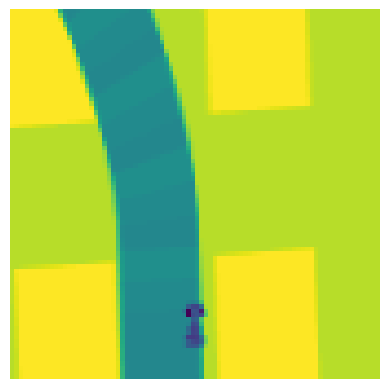

In [9]:
# Action mapping from gymnasium.farama.org
action_mapping = {
    0: "do nothing",
    1: "steer left",
    2: "steer right",
    3: "gas",
    4: "brake"
}

# Visualize random frames
idx = np.random.randint(len(dataset))
state, action = dataset[idx]
# store a single frame as we need it later for exporting an ONNX model (it needs a sample of the input for the export)
sample_state = torch.Tensor(state).unsqueeze(0).to(device)
# Display the sample
print(f"Action: {action_mapping[action]}")
plt.axis("off")
plt.imshow(state[0]);

In [10]:
# release memory
del dataset

# Define Policy Network

You need to design a neural network architecture that is capable of mapping a state to an action.
The input is a single image with the following properties:
- Resolution of 84x84 pixels
- Grayscale (meaning a single channel as opposed to three channels of an RGB image)
- The values of each pixel should be between 0 and 1

The output of the network should be one unit per possible action, as our environment has 5 actions that results in 5 output units.
Your network must implement the forward function in order to be compatible with the evaluation script.

In [11]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_units_out):
        super(PolicyNetwork, self).__init__()
        ######################
        ### YOUR CODE HERE ###
        ######################
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # output: 16 x 84 x 84
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) # output: 32 x 84 x 84
        self.pool = nn.MaxPool2d(2, 2)  # output after pooling: 32 x 42 x 42
        self.fc1 = nn.Linear(32 * 21 * 21, 120)  # Adjusted for pooled output size
        self.fc2 = nn.Linear(120, n_units_out)
        # pass

    def forward(self, x):
        ######################
        ### YOUR CODE HERE ###
        ######################
        
        # Apply convolutional layers with ReLU activation followed by max pooling
        x = self.pool(nn.functional.relu(self.conv1(x)))  # 16 x 84 x 84 -> 16 x 42 x 42
        x = self.pool(nn.functional.relu(self.conv2(x)))  # 32 x 42 x 42 -> 32 x 21 x 21
        x = x.view(-1, 32 * 21 * 21)  # Flattening
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train behavioral cloning policy

Now that you have a Dataset and a network you need to train your network.
With behavioral cloning we want to imitate the behavior of the agent that produced the demonstration dataset as close as possible.
This is basically supervised learning, where you want to minimize the loss of your network on the training and validation sets.

Some tips as to what you need to implement:
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- don't forget to evaluate your network on the validation set
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

In [12]:
# choose the batchsize for training
batch_size = 64

# Datasets
train_set = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=0, shuffle=False, drop_last=False, pin_memory=True)

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
# You can also choose to use a different logging framework such as tensorboard (not recommended on Colab) or Weights & Biases (highly recommended)
logger = Logger("logdir")
print("Saving state to {}".format(logger.basepath))

# Network
fromcheckpoint = True
model = PolicyNetwork(n_units_out=5)
model = model.to(device)
# checkpoint_path = r'C:\Users\Q540900\Desktop\A.I. Master\Second Semester\Deep Reinforcement\Assgnment 1\logdir\2024-04-15T08-27-44\params.pkl'
checkpoint_path = r'C:\Users\Q540900\Desktop\A.I. Master\Second Semester\Deep Reinforcement\Assgnment 1\logdir\2024-04-15T20-53-52\params.pkl'
if fromcheckpoint is True:
    def load_checkpoint(filepath, model):
        if os.path.isfile(filepath):
            checkpoint = torch.load(filepath)
            model.load_state_dict(checkpoint)
            print(f"Loaded model parameters from '{filepath}'")
            return model
        else:
            print(f"No checkpoint found at '{filepath}'. Starting from scratch.")
            return model
        
    # Loading the model parameters
    model = load_checkpoint(checkpoint_path, model)

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: {}".format(num_trainable_params))

######################
### YOUR CODE HERE ###
######################
# Implement your training and evaluation loop
# feel free to define your own functions for training and evaluation

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optional: Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Function to perform a training epoch
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            # print("Input batch shape:", inputs.shape)
            # print("Labels batch shape:", labels.shape)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print("Output batch shape:", outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Function to evaluate the model
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    logger.log("training_loss", train_loss)
    logger.log("validation_loss", val_loss)
    logger.log("validation_accuracy", val_acc)
    logger.dump()  # Save logs after each epoch

    if scheduler:
        scheduler.step()

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
    
    # Save the model checkpoint
    torch.save(model.state_dict(), logger.param_file)

# Save model as ONNX
sample_state = torch.randn(1, 1, 84, 84).to(device) 

# If you want to export your model as an ONNX file use the following code as template
# If you use the provided logger you can use this directly
save_as_onnx(model, sample_state, logger.onnx_file)

Loaded 50038 files from train
Loaded 9458 files from val
Saving state to logdir\2024-04-16T00-21-09
Loaded model parameters from 'C:\Users\Q540900\Desktop\A.I. Master\Second Semester\Deep Reinforcement\Assgnment 1\logdir\2024-04-15T20-53-52\params.pkl'
Trainable Parameters: 1707413


RuntimeError: stack expects each tensor to be equal size, but got [1, 84, 84] at entry 0 and [1, 4, 84, 84] at entry 43

# Evaluate the agent in the real environment

### Environment and Agent

We provide some wrappers you need in order to get the same states from the environment as in the demonstration dataset.
Additionally the `RecordState` wrapper should be very helpful in collecting new samples for the DAgger algorithm.

In [ ]:
class CropObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        gym.ObservationWrapper.__init__(self, env)
        self.shape = shape
        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return observation[:self.shape[0], :self.shape[1]]


class RecordState(gym.Wrapper):
    def __init__(self, env: gym.Env, reset_clean: bool = True):
        gym.Wrapper.__init__(self, env)

        assert env.render_mode is not None
        self.frame_list = []
        self.reset_clean = reset_clean

    def step(self, action, **kwargs):
        output = self.env.step(action, **kwargs)
        self.frame_list.append(output[0])
        return output

    def reset(self, *args, **kwargs):
        result = self.env.reset(*args, **kwargs)

        if self.reset_clean:
            self.frame_list = []
        self.frame_list.append(result[0])

        return result

    def render(self):
        frames = self.frame_list
        self.frame_list = []
        return frames


class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):
        with torch.no_grad():
            state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
            logits = self.model(state)
            if type(logits) is tuple:
                logits = logits[0]
            probs = Categorical(logits=logits)
            return probs.sample().cpu().numpy()[0]


def make_env(seed, capture_video=True):
    env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir)

    env = CropObservation(env, (84, 96))
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = RecordState(env, reset_clean=True)
    env = gym.wrappers.FrameStack(env, 4)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def run_episode(agent, show_progress=True, capture_video=True, seed=None):
    env = make_env(seed=seed, capture_video=capture_video)
    state, _ = env.reset()
    score = 0
    done = False
    if show_progress:
        progress = tqdm(desc="Score: 0")

    while not done:
        action = agent.select_action(state[-1][np.newaxis, ...])
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))
    env.close()

    if show_progress:
        progress.close()
    if capture_video:
        show_video(logger.video_dir)

    return score

## Evaluate behavioral cloning agent

Let's see how the agent is doing in the real environment

In [ ]:
train_policy = Agent(model, device)
score = run_episode(train_policy, show_progress=True, capture_video=True);
print(f"Score: {score:.2f}")

Score: 539.71: : 999it [00:29, 36.15it/s]

Moviepy - Building video c:\Users\Q540900\Desktop\A.I. Master\Second Semester\Deep Reinforcement\Assgnment 1\logdir\2024-04-15T23-38-29\videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Q540900\Desktop\A.I. Master\Second Semester\Deep Reinforcement\Assgnment 1\logdir\2024-04-15T23-38-29\videos\rl-video-episode-0.mp4



Score: 539.61: : 1000it [00:31, 31.68it/s]

Moviepy - Done !
Moviepy - video ready c:\Users\Q540900\Desktop\A.I. Master\Second Semester\Deep Reinforcement\Assgnment 1\logdir\2024-04-15T23-38-29\videos\rl-video-episode-0.mp4


Score: 539.61


Since we often have high variance when evaluating RL agents we should evaluate the agent multiple times to get a better feeling for its performance.

In [ ]:
train_policy = Agent(model, device)
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Episode:  10%|█         | 1/10 [00:15<02:20, 15.62s/it]

Score: 505


Episode:  20%|██        | 2/10 [00:31<02:05, 15.72s/it]

Score: 752


Episode:  30%|███       | 3/10 [00:45<01:45, 15.00s/it]

Score: 908


Episode:  40%|████      | 4/10 [01:01<01:32, 15.37s/it]

Score: 858


Episode:  50%|█████     | 5/10 [01:14<01:12, 14.45s/it]

Score: 917


Episode:  60%|██████    | 6/10 [01:29<00:59, 14.76s/it]

Score: 858


Episode:  70%|███████   | 7/10 [01:45<00:45, 15.18s/it]

Score: 357


Episode:  80%|████████  | 8/10 [02:01<00:31, 15.51s/it]

Score: 600


Episode:  90%|█████████ | 9/10 [02:16<00:15, 15.08s/it]

Score: 286


Episode: 100%|██████████| 10/10 [02:29<00:00, 14.94s/it]

Score: 449
Mean Score: 649.58 (Std: 227.42)


# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [ ]:
# Load expert
expert_model = ConvertModel(onnx.load("expert.onnx"))
expert_model = expert_model.to(device)
# Freeze expert weights
for p in expert_model.parameters():
    p.requires_grad = False

expert_policy = Agent(expert_model, device)

c:\Users\Q540900\AppData\Local\anaconda3\envs\dRL\lib\site-packages\onnx2pytorch\convert\layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

In [ ]:
# inner loop of DAgger
def dagger(env, train_policy, expert_policy, dataset, beta=1.):

    ######################
    ### YOUR CODE HERE ###
    ######################

    # Implement DAgger algorithm here
    # 1) Choose a policy (sample according to beta)
    # 2) Sample T-step trajectory with the chosen policy
    #    (T can be an entire episode or a single state, think about what makes more sense here and implement it accordingly)
    # 3) Label the state (or states) with your expert if they come from your training policy

    #### Note ####
    # To get an action for the current state from your training policy or expert policy:
    # action = policy.select_action(state)
    #
    # Your training policy requires a single grayscale state while
    # the expert policy requires four stacked grayscale states
    # You can prepare your state for the policy like so:
    # Train policy:
    #      np.expand_dims(state[-1], 0)
    # Expert policy:
    #      state


    # Due to the RecordState wrapper you can get the states from the environment by calling
    # env.render()
    # Doing so will clear the list and the next time you call .render() will return the new states since the last call.
    # Note: be careful with the last state

    # Finally, add collected states and the actions the expert would execute in them to the dataset
    # dataset.append(states, actions)
    T=100
    i = 0
    for t in range(T):
        states = []
        actions = []

        state, _ = env.reset()  # Reset the environment and get the initial state
        done = False
        while not done and i < 100:
            if random.random() < beta:
                # Use train policy to choose an action
                state_for_policy = np.expand_dims(state[-1], 0)  # Assuming state[-1] is the correct state format
                action = train_policy.select_action(state_for_policy)
                # Use expert policy to label the state
                expert_action = expert_policy.select_action(state)
                # Collect data: state from train policy and action from expert policy
                states.append(state_for_policy)
                actions.append(expert_action)
            else:
                # Use expert policy directly
                action = expert_policy.select_action(state)
                # Collect data: state and action both from expert policy
                states.append(state)
                actions.append(action)

            i = i + 1

            # Step the environment with the chosen action
            state, reward, done, truncated, _ = env.step(action)

            # Beta decay
            beta *= 0.999

            # Print details to check consistency
            print("Step output details - reward:", reward, "done:", done, "truncated:", truncated)
            print("Beta value after decay:", beta)

        # Append collected data to dataset
        dataset.append(states, actions)

Put everything together now.
1. Create new samples using the DAgger algorithm
2. Continue training your agent
3. Export your fully trained agent as an ONNX file

In [ ]:
# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
logger = Logger("logdir_dagger")
print("Saving state to {}".format(logger.basepath))

# start environment
env = make_env(seed=42, capture_video=False)

# Training
######################
### YOUR CODE HERE ###
######################

# Initialize your agent
model = PolicyNetwork(n_units_out=5).to(device)
train_policy = Agent(model, device)

# Load and setup the expert model
expert_model_onnx = onnx.load("expert.onnx")
expert_model = ConvertModel(expert_model_onnx).to(device)
for p in expert_model.parameters():
    p.requires_grad = False
expert_policy = Agent(expert_model, device)

# Dataset for training
dataset = DemonstrationDataset("train")

# DAgger training loop configuration
num_iterations = 10  # Number of DAgger iterations
num_episodes_per_iteration = 5  # Number of episodes per iteration

for iteration in range(num_iterations):
    beta = max(0.5 * (0.85 ** iteration), 0.1)  # Decay beta, not below 0.1

    for _ in range(num_episodes_per_iteration):
        dagger(env, train_policy, expert_policy, dataset, beta=beta)
    
    # After collecting new data, retrain the model
    # Assuming train_model function handles model training logic
    rain_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

    # Periodic model checkpointing
    torch.save(model.state_dict(), logger.param_file)

# Save the fully trained model to an ONNX file
sample_input = torch.randn(1, 1, 84, 84).to(device)

save_as_onnx(model, sample_state, logger.onnx_file)
env.close()

Saving state to logdir_dagger\2024-04-16T00-06-09


Loaded 49538 files from train
Step output details - reward: 6.457377049180328 done: False truncated: False
Beta value after decay: 0.4995
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4990005
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4985014995
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4980029980005
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4975049950024995
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.497007490007497
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4965104825174895
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.49601397203497205
Step output details

C:\Users\Q540900\AppData\Local\Temp\ipykernel_9312\46999519.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale


Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4950224401048741
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.49452741766476926
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4940328902471045
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4935388573568574
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4930453184995005
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.49255227318100103
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.49205972090782
Step output details - reward: -0.09999999999999964 done: False truncated: False
Beta value after decay: 0.4915676611869122
Step output deta

KeyboardInterrupt: 

In [ ]:
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))